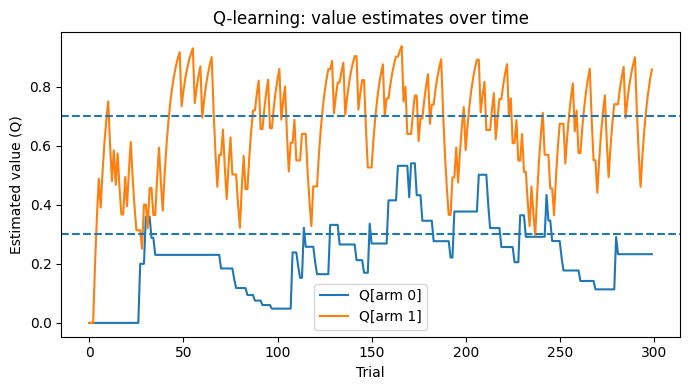

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# softmax: turn values -> probs
# -------------------------------
def softmax(z):
    """
    Convert a real-valued vector z into a probability distribution.
    - subtract max(z) for numerical stability (doesn't change resulting probs)
    - exp and normalize so elements are >0 and sum to 1
    """
    z = np.asarray(z, float)
    z -= z.max()          # stability trick
    e = np.exp(z)
    return e / e.sum()

# -----------------------------------------------
# simulate: Q-learning in a K-armed bandit
# -----------------------------------------------
def simulate_qlearning(T, p, alpha=0.2, beta=4.0, seed=None):
    """
    T: number of trials
    p: array-like of reward probabilities for each arm (Bernoulli 0/1 reward)
    alpha: learning rate (0..1) | how fast Q moves toward observed reward
    beta: inverse temperature (>0) | how deterministic the softmax policy is
    seed: RNG seed for reproducibility

    Returns:
      choices  (T,): chosen arm index each trial
      rewards  (T,): realized reward (0.0 or 1.0 here)
      Q_traces (T,K): Q-values snapshot AFTER each update
    """
    rng = np.random.default_rng(seed)
    p = np.asarray(p, float)
    K = p.size

    # Start “uninformed”: all action values at 0
    Q = np.zeros(K, float)

    # Preallocate logs for speed and clarity
    Q_traces = np.zeros((T, K), float)
    choices = np.empty(T, int)
    rewards = np.empty(T, float)

    for t in range(T):
        # ---- POLICY: convert current Q into choice probabilities
        probs = softmax(beta * Q)

        # ---- ACT: sample an action according to those probabilities
        a = rng.choice(K, p=probs)

        # ---- ENV: draw a Bernoulli reward with success prob p[a]
        r = float(rng.random() < p[a])  # 1.0 on success else 0.0

        # ---- LEARN: Q-learning update for the chosen action
        # prediction error = observed - expected
        pe = r - Q[a]
        Q[a] += alpha * pe

        # ---- LOG: keep the full trajectory
        Q_traces[t] = Q
        choices[t] = a
        rewards[t] = r

    return choices, rewards, Q_traces

# ---------- tiny demo + plot ----------
if __name__ == "__main__":
    # Two-armed bandit: arm0 pays 30%, arm1 pays 70%
    T = 300
    p = [0.3, 0.7]
    alpha = 0.2
    beta = 4.0

    choices, rewards, Qs = simulate_qlearning(T, p, alpha, beta, seed=1)

    # Plot Q trajectories vs the true expected rewards (dashed lines)
    plt.figure(figsize=(7,4))
    plt.plot(Qs[:,0], label="Q[arm 0]")
    plt.plot(Qs[:,1], label="Q[arm 1]")
    plt.axhline(p[0], linestyle="--")
    plt.axhline(p[1], linestyle="--")
    plt.xlabel("Trial")
    plt.ylabel("Estimated value (Q)")
    plt.title("Q-learning: value estimates over time")
    plt.legend()
    plt.tight_layout()
    plt.show()
